In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
from sklearn.preprocessing import StandardScaler, PowerTransformer
from pysal.model import mgwr

In [2]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
ROME_GEOJSON = (
    PATH_TO_PROCESSED_FILES / "Rome_urban_zones_with_features_and_emissions__epsg4326.geojson"
)

PATH_TO_OUTPUT = Path("../reports/figures/")

SAVE_FIG = False
axis_label_fontsize=21
axis_ticklabel_fontsize=20

FIT_INTERCEPT = True

In [3]:
gdf_rome = gpd.read_file(ROME_GEOJSON)
print(gdf_rome.shape)

gdf_rome_connected = gdf_rome.drop(index=[97])

#gdf_rome_connected_proj = gdf_rome_connected.to_crs('epsg:32632')

coords = np.column_stack([gdf_rome_connected["geometry"].centroid.x, gdf_rome_connected["geometry"].centroid.y])
gdf_rome_connected["centroid"] = gdf_rome_connected["geometry"].centroid

## NOTE: these warning are not a problem because when defining the GWR we can specify that 
##       the coordinates are spherical (lat-lng)

(155, 36)


/tmp/ipykernel_25255/3477478901.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.column_stack([gdf_rome_connected["geometry"].centroid.x, gdf_rome_connected["geometry"].centroid.y])
/tmp/ipykernel_25255/3477478901.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.column_stack([gdf_rome_connected["geometry"].centroid.x, gdf_rome_connected["geometry"].centroid.y])
/tmp/ipykernel_25255/3477478901.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_rome_connected["centroid"] = gdf_rome_connected["geometry"].centroid


In [4]:
feature_to_predict = "avg_CO_2_per_road"

all_predictors = [
    'n_traffic_lights', 'density_traffic_lights', 
    'n_shops', 'density_shops', 
    'street_len_tot', 'street_density', 'motorway_ratio',
    'motorway_roads_density', 'trunk_roads_density',
    'primary_roads_density', 'all_heavy_roads_density',
    'n_food_amenities', 'density_food_amenities', 
    'n_education_amenities', 'density_education_amenities', 
    'n_service_amenities', 'density_service_amenities', 
    'n_all_amenities', 'density_all_amenities',
    'perc_roads_bc', 'car_accidents',
    'perc_people_close_to_public_transport', 'pop_density',
]

## Geographically Weighted Regression

### All (uncorrelated) features

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

variables_to_check = [
    'density_traffic_lights',
    #'density_shops', #
    'street_density',
    #'motorway_ratio', #
    'motorway_roads_density', 
    'trunk_roads_density',
    'primary_roads_density', 
    #'all_heavy_roads_density', #
    #'density_food_amenities', #
    #'density_education_amenities', #
    #'density_service_amenities', #
    'density_all_amenities',
    'perc_roads_bc',
    'car_accidents',
    'perc_people_close_to_public_transport',
    'pop_density'
]

#variables_to_check = all_predictors

features = "+".join(variables_to_check)
y_vif, X_vif = dmatrices('avg_CO_2_per_road ~' + features, gdf_rome_connected[[feature_to_predict]+variables_to_check], return_type='dataframe')

###Calculate VIF Factors
vif=pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values,i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns

print(vif.round(1))

    VIF Factor                               features
0         11.0                              Intercept
1          3.0                 density_traffic_lights
2          3.5                         street_density
3          1.2                 motorway_roads_density
4          1.1                    trunk_roads_density
5          1.2                  primary_roads_density
6          2.2                  density_all_amenities
7          1.2                          perc_roads_bc
8          1.4                          car_accidents
9          1.8  perc_people_close_to_public_transport
10         2.5                            pop_density


In [6]:
non_correlated_features = vif.loc[vif['VIF Factor'] <= 5, 'features'].to_list()
non_correlated_features

['density_traffic_lights',
 'street_density',
 'motorway_roads_density',
 'trunk_roads_density',
 'primary_roads_density',
 'density_all_amenities',
 'perc_roads_bc',
 'car_accidents',
 'perc_people_close_to_public_transport',
 'pop_density']

In [7]:
X = gdf_rome_connected[non_correlated_features]
y = gdf_rome_connected[feature_to_predict]

In [8]:
# transforming (and scaling) y
pwt = PowerTransformer()
pwt.fit(y.values.reshape(-1, 1))

y_transformed = pwt.transform(y.values.reshape(-1, 1))

# scaling X
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

### GWR

In [9]:
# bandwidth selection
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(
    coords, y_transformed, X_scaled, fixed=False, spherical=True, multi=False, kernel='gaussian'
)

gwr_bw = gwr_chosen_selector.search(verbose=True)

Bandwidth:  97.0 , score:  296.75
Bandwidth:  119.0 , score:  297.96
Bandwidth:  84.0 , score:  296.38
Bandwidth:  75.0 , score:  296.04
Bandwidth:  70.0 , score:  295.87
Bandwidth:  67.0 , score:  295.80
Bandwidth:  65.0 , score:  295.83
Bandwidth:  68.0 , score:  295.75
Bandwidth:  69.0 , score:  295.86


In [10]:
# fitting GWR
gwr_model = mgwr.gwr.GWR(
    coords, y_transformed, X_scaled, gwr_bw, constant=FIT_INTERCEPT
)
gwr_results = gwr_model.fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 154
Number of covariates:                                                    11

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             53.264
Log-likelihood:                                                    -136.766
AIC:                                                                295.531
AICc:                                                               299.744
BIC:                                                               -667.021
R2:                                                                   0.654
Adj. R2:                                                              0.630

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Multiscale GWR

In [ ]:
# MGWR

mgwr_selector = mgwr.sel_bw.Sel_BW(
    coords, y_transformed, X_scaled, fixed=False, spherical=True, multi=True, kernel='gaussian'
)
mgwr_bw = mgwr_selector.search(verbose=True)

In [ ]:
mgwr_model = mgwr.gwr.MGWR(
    coords, y_transformed, X_scaled, mgwr_selector, constant=FIT_INTERCEPT
)
mgwr_results = mgwr_model.fit()
mgwr_results.summary()

In [ ]:
# MGWR predictions
y_pred_transformed = mgwr_results.predy

# inverse transforming predictions
y_pred = pwt.inverse_transform(y_pred_transformed)

In [ ]:
mgwr_results.params

In [11]:
# GWR predictions
gwr_model.predict(coords, X_scaled)
y_pred_transformed = gwr_results.predictions


# inverse transforming predictions
y_pred = pwt.inverse_transform(y_pred_transformed)

> regression results <
Mean squared error: 0.16
Root mean squared error: 0.40
Median absolute error: 0.29
Coefficient of determination: 0.84



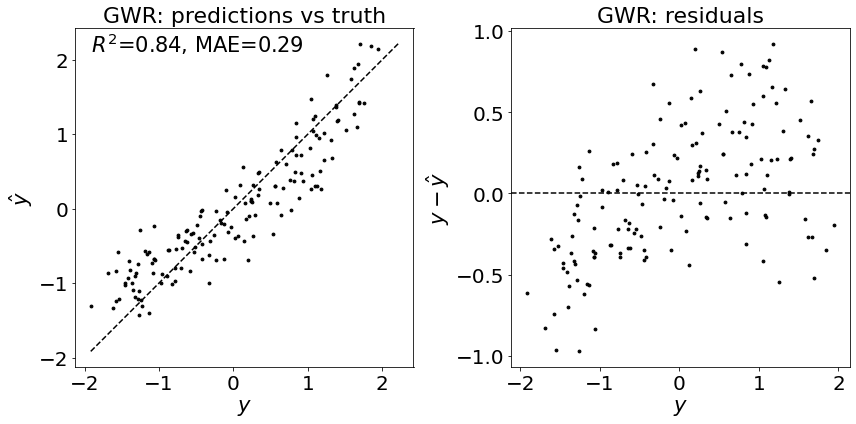

In [12]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

res_transformed = [y_transformed[i]-y_pred_transformed[i] for i in range(len(y_transformed))]

print('> regression results <')
#print("Coefficients: \n", model.coef_)
#print("Intercept: ", model.intercept_)
mse = mean_squared_error(y_transformed, y_pred_transformed)
rmse = mean_squared_error(y_transformed, y_pred_transformed, squared=False)
mae = median_absolute_error(y_transformed, y_pred_transformed)
r2 = r2_score(y_transformed, y_pred_transformed)
print("Mean squared error: %.2f" % mse)
print("Root mean squared error: %.2f" % rmse)
print("Median absolute error: %.2f" % mae)
print("Coefficient of determination: %.2f" % r2)
print('')

# plotting the results
f, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].scatter(y_transformed, y_pred_transformed, color='black', s=8)
p1 = max(max(y_pred_transformed), max(y_transformed))
p2 = min(min(y_pred_transformed), min(y_transformed))
axs[0].plot([p1, p2], [p1, p2], '--k')
axs[0].set_ylabel(r'$\hat{y}$', fontsize=axis_label_fontsize)
axs[0].set_xlabel(r'$y$', fontsize=axis_label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
axs[0].set_title('GWR: predictions vs truth', fontsize=22)
axs[0].text(p2, max(y_pred_transformed)-(max(y_pred_transformed)/100*5), '$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_transformed, y_pred_transformed), median_absolute_error(y_transformed, y_pred_transformed)),
    fontdict={'size':axis_label_fontsize})
axs[1].scatter(y_transformed, res_transformed, color='black', s=8)
axs[1].axhline(0, linestyle='--', color='black')
axs[1].set_ylabel(r'$y-\hat{y}$', fontsize=axis_label_fontsize)
axs[1].set_xlabel(r'$y$', fontsize=axis_label_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
axs[1].set_title('GWR: residuals', fontsize=22)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'predictions_GWR.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'predictions_GWR.png', format='png', dpi=300)

In [ ]:
gdf_rome_connected["Local_R2"] = gwr_results.localR2

fig, ax = plt.subplots(figsize=(15, 15))
gdf_rome_connected.plot(
    ax=ax,
    edgecolor="black",
    column="Local_R2",
    legend=True,
    vmin=0,
    vmax=1,
    cmap="tab20b",
    legend_kwds={"shrink": 0.7},
)

ax.set_title(
    "Local R2 with KNN = {}".format(int(gwr_bw)),
    fontsize=20,
)
ax.set_axis_off()

plt.show()

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


Moran's I:  0.0795836952411369 0.04


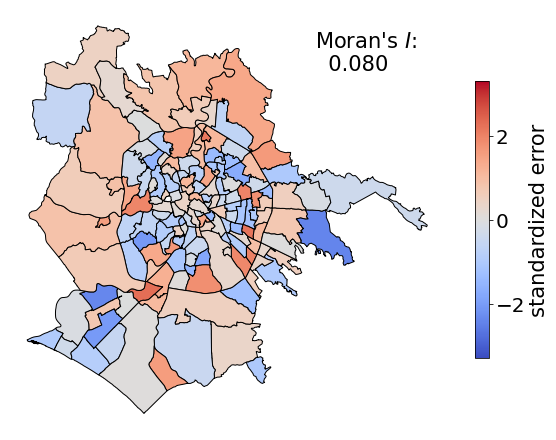

In [13]:
# standardized residuals
error_to_plot = (y_transformed - y_pred_transformed) / np.std(y_transformed - y_pred_transformed)

gdf_rome_connected["Chosen_Error"] = error_to_plot

## Global Moran's I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran

w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1
moran = esda.moran.Moran(gdf_rome_connected["Chosen_Error"], w)
print("Moran's I: ", moran.I, moran.p_sim)
##

col_lim = max(abs(gdf_rome_connected["Chosen_Error"].min()), abs(gdf_rome_connected["Chosen_Error"].max()))
#print(col_lim)

fig, ax = plt.subplots(figsize=(8, 8))

gdf_rome_connected.plot(
    ax=ax,
    column="Chosen_Error",
    legend=True,
    #figsize=(15, 15),
    edgecolor="black",
    cmap="coolwarm",
    vmin=-3.3,
    vmax=3.3,
    legend_kwds={"shrink": 0.5},
)
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=axis_ticklabel_fontsize)
cbar.set_ylabel('standardized error', fontsize=axis_label_fontsize)

ax.text(0.7, 0.85, "Moran's $I$: \n  %.3f" %moran.I, fontdict={'size':axis_label_fontsize}, transform=ax.transAxes)

#ax.set_title("Relative errors in spatial model", fontsize=20, y=1.01)
ax.set_axis_off()
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'map_errors_GWR.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(PATH_TO_OUTPUT / 'map_errors_GWR.png', format='png', bbox_inches='tight', dpi=300)

plt.show()

In [14]:
## Global Moran's I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran

# spatial weights
w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1

# 
moran = esda.moran.Moran(gdf_rome_connected["Chosen_Error"], w)
moran.I, moran.p_sim

(0.0795836952411369, 0.047)

In [15]:
exp_moran = -1/(w.n-1)
exp_moran

-0.006535947712418301

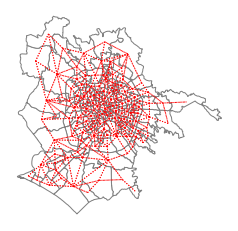

In [16]:
gdf_plot = gdf_rome_connected.reset_index()

ax = gdf_plot.plot(edgecolor='grey', facecolor='w')
f,ax = w.plot(gdf_plot, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

### Features' importance in each area

In [17]:
gwr_columns = X.columns
if FIT_INTERCEPT:
    gwr_columns = gwr_columns.insert(0, "Intercept")
coefs_gwr = pd.DataFrame(gwr_results.params, columns=gwr_columns)

medians_gwr = coefs_gwr.median()
medians_gwr = medians_gwr.reindex(medians_gwr.abs().sort_values(ascending=False).index)
coefs_gwr = coefs_gwr[medians_gwr.index]

limit_value = (
    max(abs(coefs_gwr.to_numpy().min()), abs(coefs_gwr.to_numpy().max())) * 1.05
)

In [18]:
geo_coefs = gdf_rome_connected[['area_name', 'geometry', 'centroid']].copy()

for col in coefs_gwr.columns:
    #     if col != "Intercept":
    #     if True:
    geo_coefs.loc[:,col] = coefs_gwr[col].values


# Get t-vals of coefficientes
gwr_filtered_t = pd.DataFrame(gwr_results.filter_tvals(), columns=gwr_columns)
gwr_filtered_t.index = gdf_rome_connected.index

# Copy coefficients in new dataframe so non-significant can later be removed
geo_significant_coefs = geo_coefs.copy()

In [19]:
table_coefs = pd.DataFrame(geo_coefs.drop(['geometry','centroid', 'area_name'], axis=1))
table_coefs.index = geo_coefs['area_name']
table_coefs

,motorway_roads_density,pop_density,trunk_roads_density,car_accidents,perc_people_close_to_public_transport,perc_roads_bc,Intercept,street_density,density_all_amenities,density_traffic_lights,primary_roads_density
area_name,,,,,,,,,,,
Morena,0.535472,-0.529194,-0.253030,-0.020779,-0.210312,0.141927,-0.087261,0.452636,0.196564,-0.156451,0.109725
Don Bosco,0.629681,-0.375931,-0.200651,0.080095,-0.215736,0.244060,-0.150611,0.328976,0.068390,-0.100320,0.044571
Appio-Claudio,0.666238,-0.395497,-0.211921,0.099906,-0.202547,0.201776,-0.171574,0.358574,0.073528,-0.130556,0.093898
Quarto Miglio,0.645796,-0.442400,-0.136178,0.111980,-0.198939,0.127658,-0.131156,0.350437,0.091992,-0.153153,0.152155
Pignatelli,0.737713,-0.344169,-0.020433,0.189436,-0.203193,0.176240,-0.154351,0.231828,0.072591,-0.088542,0.152128
...,...,...,...,...,...,...,...,...,...,...,...
Tuscolano Nord,0.637972,-0.140019,0.236227,0.218022,-0.188036,0.328583,-0.313947,-0.031011,0.040015,0.181756,-0.034924
Tuscolano Sud,0.695853,-0.163102,0.195044,0.203046,-0.200702,0.372264,-0.243321,0.005892,0.053804,0.122472,-0.017798
Tor Fiscale,0.757840,-0.272380,0.015254,0.177109,-0.198231,0.289215,-0.167061,0.161000,0.059253,-0.015536,0.056776


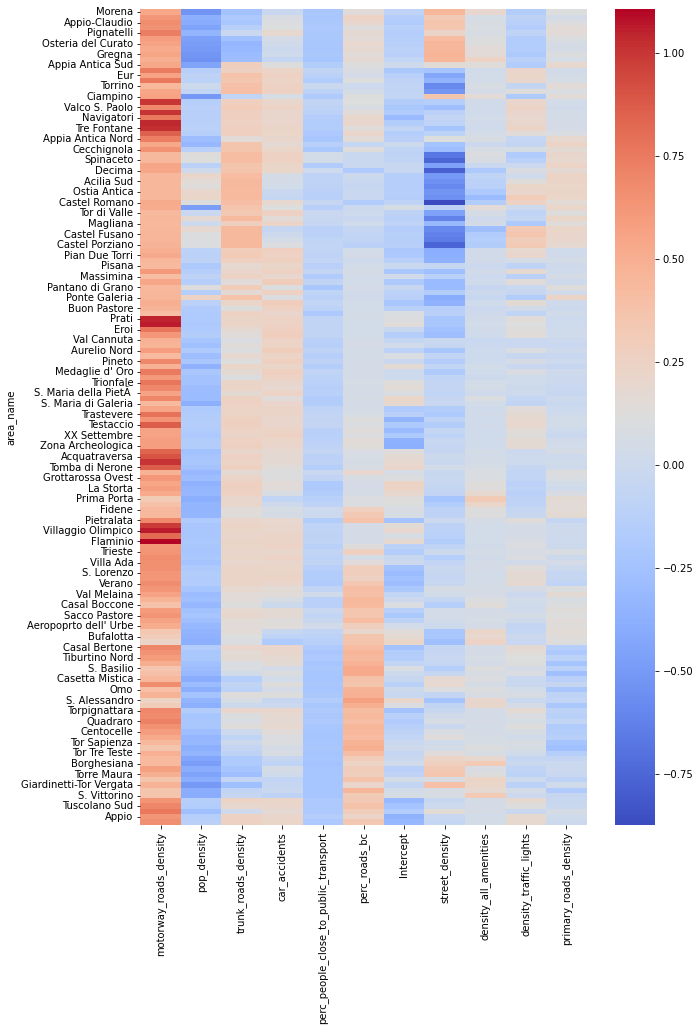

In [29]:
fig, ax = plt.subplots(figsize=(10,15))
ax = sns.heatmap(table_coefs, ax=ax, cmap='coolwarm')

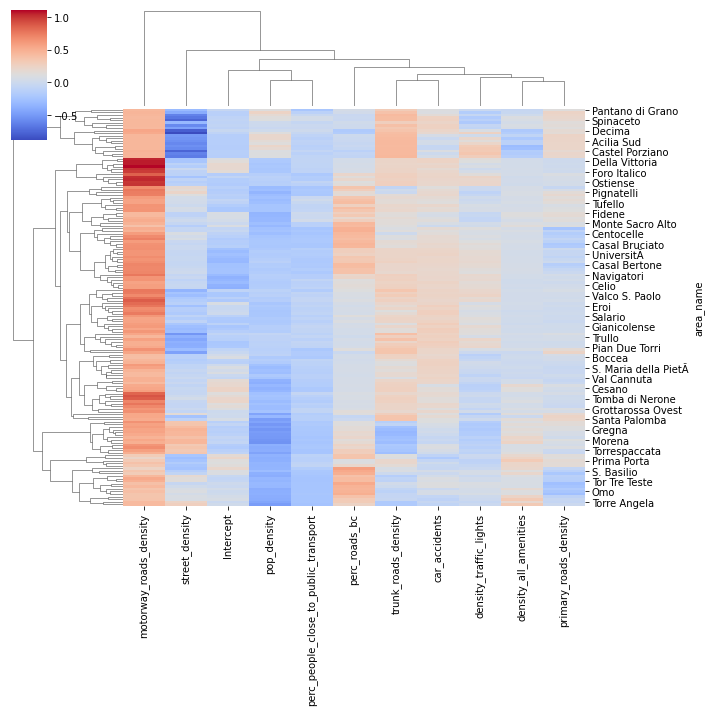

In [30]:
ax = sns.clustermap(table_coefs, cmap='coolwarm')

In [17]:
gwr_filtered_t.describe()

,Intercept,density_traffic_lights,street_density,motorway_roads_density,trunk_roads_density,primary_roads_density,density_all_amenities,perc_roads_bc,car_accidents,perc_people_close_to_public_transport,pop_density
count,154.000000,154.0,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.0,154.000000
mean,-0.107802,0.0,-0.349407,5.196558,1.608420,0.016700,0.021037,0.602887,0.867139,0.0,-1.045342
std,0.537533,0.0,1.048368,1.031014,1.933000,0.207246,0.261061,1.235526,1.367508,0.0,1.481735
min,-2.959272,0.0,-4.533933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-3.768589
25%,0.000000,0.0,0.000000,4.608710,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-2.784230
50%,0.000000,0.0,0.000000,5.372873,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.000000,0.0,0.000000,5.900491,3.177931,0.000000,0.000000,0.000000,2.644033,0.0,0.000000
max,0.000000,0.0,0.000000,7.034555,5.874429,2.571861,3.239679,3.636144,3.916793,0.0,0.000000


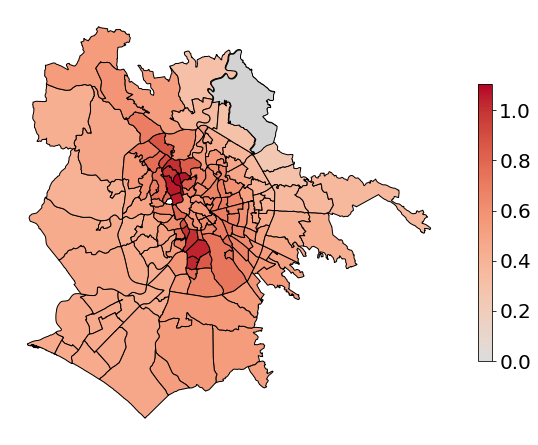

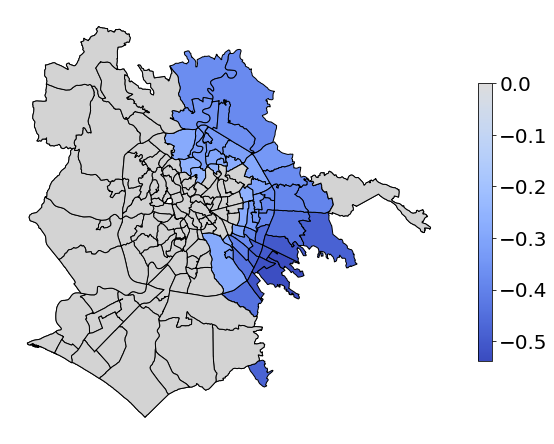

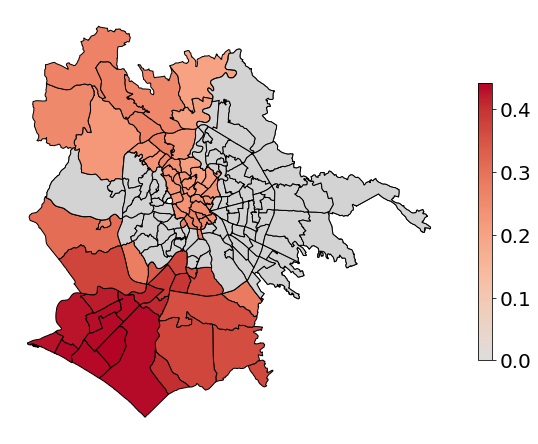

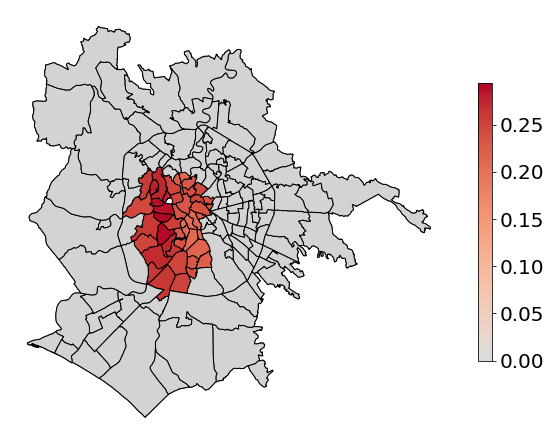

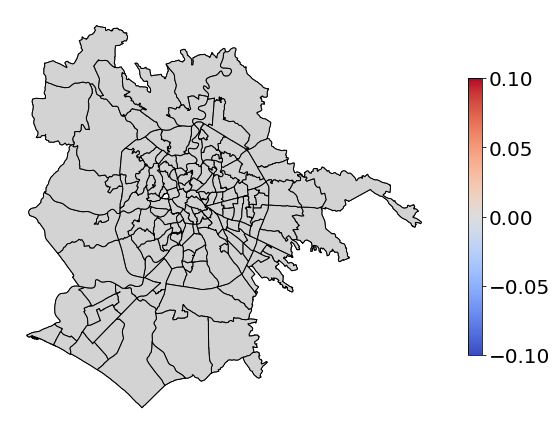

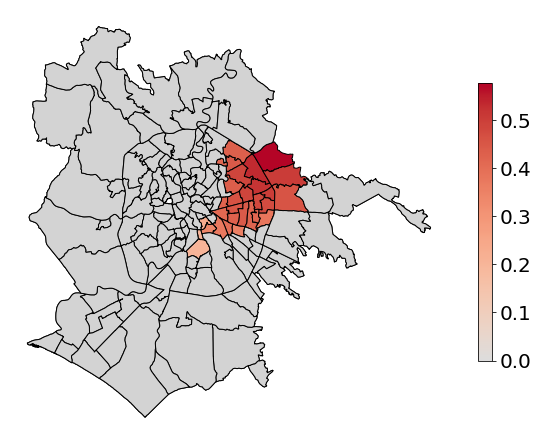

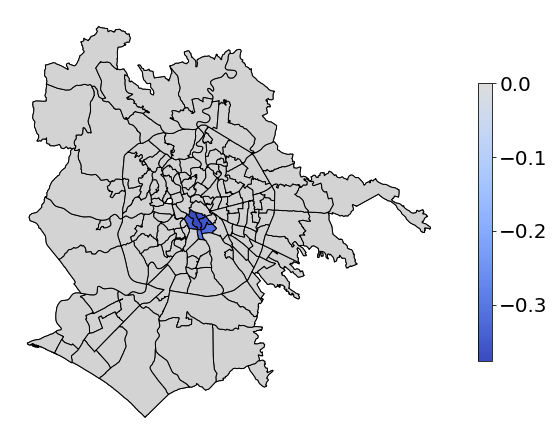

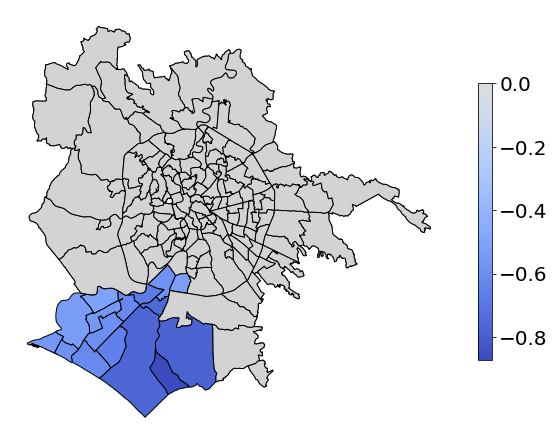

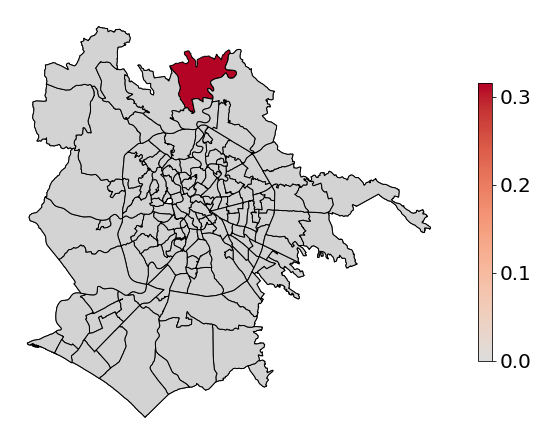

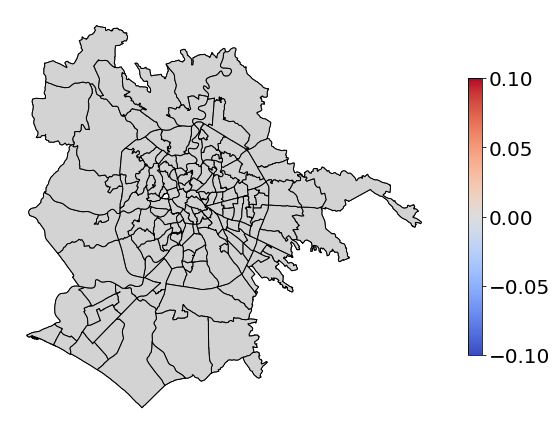

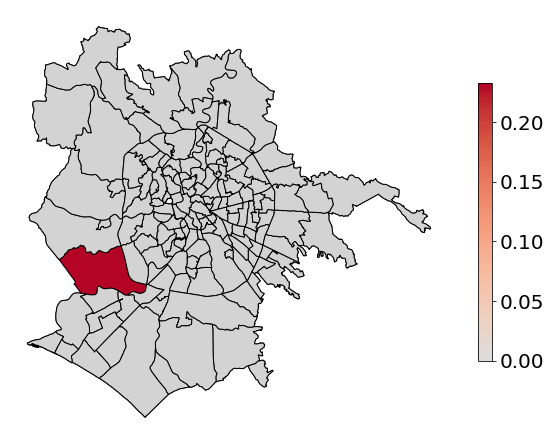

In [25]:
for col in coefs_gwr.columns:
    fig, ax = plt.subplots(figsize=(8, 8))
    min_coef = geo_coefs[gwr_filtered_t.loc[:, col] != 0][col].min()
    max_coef = geo_coefs[gwr_filtered_t.loc[:, col] != 0][col].max()

    cool_warm_cmap = plt.cm.coolwarm

    if min_coef < 0 and max_coef < 0:
        interval = np.linspace(0, 0.5)
        colors = cool_warm_cmap(interval)
        cool_warm_cmap = plt_colors.LinearSegmentedColormap.from_list("name", colors)
        vmin = min_coef
        vmax = 0
    elif min_coef > 0 and max_coef > 0:
        interval = np.linspace(0.5, 1)
        colors = cool_warm_cmap(interval)
        cool_warm_cmap = plt_colors.LinearSegmentedColormap.from_list("name", colors)
        vmin = 0
        vmax = max_coef
    else:
        vmax = max(abs(min_coef), abs(max_coef))
        vmin = -vmax

    geo_coefs.plot(
        ax=ax,
        edgecolor="black",
        column=col,
        legend=True,
        vmin=vmin,
        vmax=vmax,
        cmap=cool_warm_cmap,
        legend_kwds={"shrink": 0.5},
    )
    if (gwr_filtered_t.loc[:, col] == 0).any():
        geo_coefs[gwr_filtered_t.loc[:, col] == 0].plot(
            color="lightgrey", ax=ax, **{"edgecolor": "black"}
        )
        temp = geo_significant_coefs[[col]]
        temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
        geo_significant_coefs.loc[:,col] = temp[col]
    
    cbar = ax.get_figure().get_axes()[1]
    cbar.tick_params(labelsize=axis_ticklabel_fontsize)
    #cbar.set_ylabel('coefficient', fontsize=axis_label_fontsize)

    #ax.set_title("Coefficients of {}".format(col), fontsize=20, y=1.01)
    ax.set_axis_off()
    plt.tight_layout()
    #'''
    
    if SAVE_FIG:
        plt.savefig(
            PATH_TO_OUTPUT / "map_coefficients_GWR_{}.png".format(col),
            format="png", bbox_inches='tight', dpi=300
        )
    #'''

    plt.show()

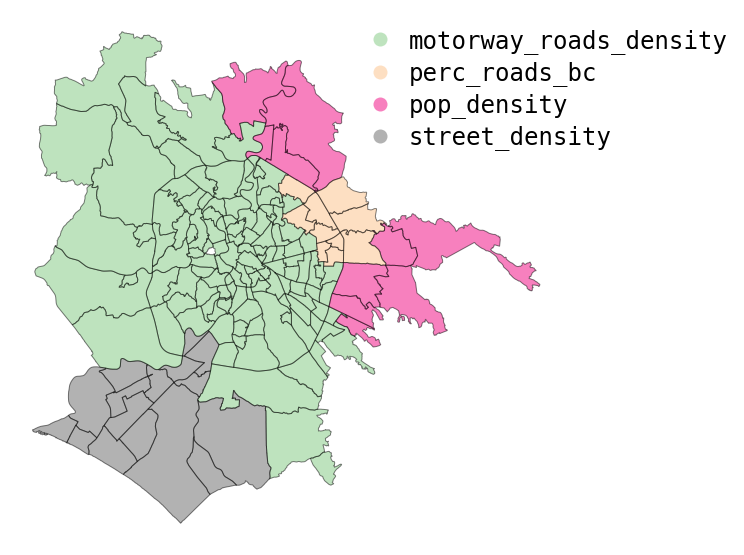

In [47]:
df_significant_coefs = pd.DataFrame(geo_significant_coefs.drop(['area_name', 'geometry', 'centroid'], axis=1))

gdf_rome_connected["Most_Important_Feature"] = (
    df_significant_coefs.fillna(0).abs().idxmax(axis=1).values
)

temp = gdf_rome_connected["Most_Important_Feature"].copy()
temp.loc[df_significant_coefs.fillna(0).abs().max(axis=1) == 0] = "!NONE"
gdf_rome_connected["Most_Important_Feature"] = temp



fig, ax = plt.subplots(figsize=(10, 10))
gdf_rome_connected.plot(
    ax=ax,
    edgecolor="black",
    cmap="Accent",
    alpha=0.5,
    column="Most_Important_Feature",
    legend=True, legend_kwds={'prop':{'family':'monospace', 'size':24}, 'markerscale':1.4,  'bbox_to_anchor':(1.33,1), 
                              'frameon':False, 'handletextpad':0.2, 'labelspacing':0.3}
)
'''
ax.set_title(
    "Most important feature per area",
    fontsize=20,
    y=1.01,
)
'''
ax.set_axis_off()

SAVE_FIG=True
if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'map_important_feat_GWR.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(PATH_TO_OUTPUT / 'map_important_feat_GWR.png', format='png', bbox_inches='tight', dpi=300)

plt.show()

### GWR vs MGWR results

In [ ]:
gwr_columns = X.columns
if FIT_INTERCEPT:
    gwr_columns = gwr_columns.insert(0, "Intercept")
coefs_gwr = gpd.GeoDataFrame(gwr_results.params, columns=gwr_columns, geometry=gdf_rome_connected['geometry'])
coefs_gwr["geometry"] = gdf_rome_connected['geometry']

gwr_filtered_t = gwr_results.filter_tvals()


mgwr_columns = X.columns
if FIT_INTERCEPT:
    mgwr_columns = mgwr_columns.insert(0, "Intercept")
coefs_mgwr = gpd.GeoDataFrame(mgwr_results.params, columns=mgwr_columns, geometry=gdf_rome_connected['geometry'])
#coefs_mgwr["geometry"] = gdf_rome_connected['geometry']

mgwr_filtered_t = mgwr_results.filter_tvals()

In [ ]:
gdf_to_plot = gdf_rome_connected.copy()

#Add GWR parameters to GeoDataframe
gdf_to_plot['gwr_intercept'] = gwr_results.params[:,0]
gdf_to_plot['gwr_fb'] = gwr_results.params[:,1]
gdf_to_plot['gwr_aa'] = gwr_results.params[:,2]
gdf_to_plot['gwr_rural'] = gwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

#Add MGWR parameters to GeoDataframe
gdf_to_plot['mgwr_intercept'] = mgwr_results.params[:,0]
gdf_to_plot['mgwr_fb'] = mgwr_results.params[:,1]
gdf_to_plot['mgwr_aa'] = mgwr_results.params[:,2]
gdf_to_plot['mgwr_rural'] = mgwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

In [ ]:
#Comparison maps of GWR vs. MGWR parameter surfaces where the grey units pertain to statistically insignificant parameters
from mgwr.utils import shift_colormap, truncate_colormap

#Prep plot and add axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Intercept Surface (BW: ' + str(mgwr_bw[0]) +')', fontsize=40)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
gwr_min = gdf_to_plot['gwr_intercept'].min()
gwr_max = gdf_to_plot['gwr_intercept'].max()
mgwr_min = gdf_to_plot['mgwr_intercept'].min()
mgwr_max = gdf_to_plot['mgwr_intercept'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
gdf_to_plot.plot('gwr_intercept', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,0] == 0).any():
    gdf_to_plot[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

#Plot MGWR parameters
gdf_to_plot.plot('mgwr_intercept', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (mgwr_filtered_t[:,0] == 0).any():
    gdf_to_plot[mgwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})

fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Comparison maps of GWR vs. MGWR parameter surfaces where the grey units pertain to statistically insignificant parameters
from mgwr.utils import shift_colormap, truncate_colormap

for i, c_feat in enumerate(coefs_gwr.columns):
    #Prep plot and add axes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
    ax0 = axes[0]
    ax0.set_title('GWR %s Surface (BW: ' %c_feat + str(gwr_bw) +')', fontsize=40)
    ax1 = axes[1]
    ax1.set_title('MGWR %s Surface (BW: ' %c_feat + str(mgwr_bw[i]) +')', fontsize=40)

    #Set color map
    cmap = plt.cm.seismic

    #Find min and max values of the two combined datasets
    gwr_min = coefs_gwr[c_feat].min()
    gwr_max = coefs_gwr[c_feat].max()
    mgwr_min = coefs_mgwr[c_feat].min()
    mgwr_max = coefs_mgwr[c_feat].max()
    vmin = np.min([gwr_min, mgwr_min])
    vmax = np.max([gwr_max, mgwr_max])

    #If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    #If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

    #Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    #Plot GWR parameters
    coefs_gwr.plot(c_feat, cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
    #If there are insignificnt parameters plot gray polygons over them
    if (gwr_filtered_t[:,i] == 0).any():
        coefs_gwr[gwr_filtered_t[:,i] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

    #Plot MGWR parameters
    coefs_mgwr.plot(c_feat, cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
    #If there are insignificnt parameters plot gray polygons over them
    if (mgwr_filtered_t[:,i] == 0).any():
        coefs_mgwr[mgwr_filtered_t[:,i] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})

    fig.tight_layout()    
    fig.subplots_adjust(right=0.9)
    cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=50) 
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
mgwr_bw

In [ ]:
coefs_gwr.columns